In [58]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [18]:
BATCH_SIZE = 16
IMAGE_SIZE = 150

In [19]:
generator = ImageDataGenerator(rescale=1./255)

In [39]:
#Retrieve images and divide into three classes
dataset = generator.flow_from_directory(
   "./dataset_2",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assumes categorical labels
    shuffle=True
)

Found 4175 images belonging to 25 classes.


In [40]:
class_names = list(dataset.class_indices.keys())
class_names

['Air Terjun Oenesu',
 'Air Terjun Tanggedu',
 'Air Terjun Tesbatan',
 'Bukit Wairinding',
 'Danau Kelimut',
 'Gua Rangko',
 'Lawa Darat Gili',
 'Lingko Spider Web Rice Field',
 'Pandar Island',
 'Pantai Koka',
 'Pantai Kolbano',
 'Pantai Mandorak',
 'Pantai Oetune',
 'Pantai Waecicu',
 'Pantai Walakiri',
 'Pantai Watu Parunu',
 'Pink Beach',
 'Pulau Kalong',
 'Pulau Kanawa',
 'Rumah Budaya Sumba',
 'Savana Puru Kambera',
 'Taman Nostalgia Kupang',
 'Wae Rebo Village',
 'Waikuri Lagoon',
 'Wisata Adat Kampung Todo']

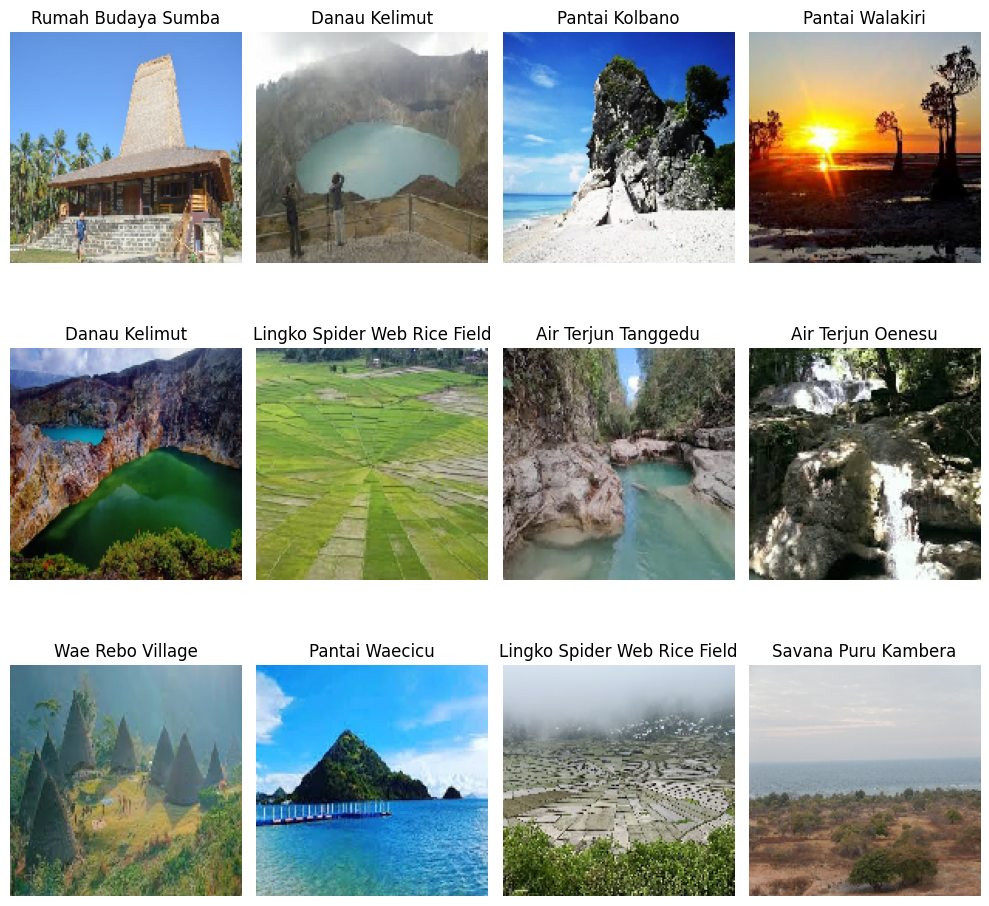

In [41]:
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 12)):  # Plot up to 12 images
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i].argmax()])  # Use argmax to get the label index
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get one batch of data
images, labels = next(dataset)

# Visualize the batch of images
plot_images(images, labels, class_names)

In [67]:
min_value = tf.reduce_min(images)
print("Minimum pixel value:", min_value.numpy())
min_value = tf.reduce_max(images)
print("Maximum pixel value:", min_value.numpy())

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [68]:
dataset_size = len(dataset.filenames)
train_size = int(dataset_size * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - val_size

In [69]:
train_dataset = generator.flow_from_directory(
    "./dataset_2",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assumes categorical labels
    subset='training',  # Specify subset as 'training' for training set
    shuffle=True
)

Found 4175 images belonging to 25 classes.


In [70]:
val_dataset = generator.flow_from_directory(
    "./dataset_2",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assumes categorical labels
    subset='validation',  # Specify subset as 'validation' for validation set
    shuffle=True
)

Found 0 images belonging to 25 classes.


In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
BATCH_SIZE = 16
IMAGE_SIZE = 150

# ImageDataGenerator with rescaling
generator = ImageDataGenerator(rescale=1./255)

# Load images from directory for training dataset
train_dataset = generator.flow_from_directory(
    "./dataset_2",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assumes categorical labels
    subset='training',  # Specify subset as 'training' for training set
    shuffle=True
)

Found 4175 images belonging to 25 classes.


In [72]:
val_dataset = generator.flow_from_directory(
    "./dataset_2",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assumes categorical labels
    subset='validation',  # Specify subset as 'validation' for validation set
    shuffle=True
)

Found 0 images belonging to 25 classes.
